In [1]:
# imports the numpy and matplotlib. Also ensures plots appear inline
# import matplotlib.pyplot as plt
# import numpy as np
%pylab inline
import pandas as pd
import time
import statistics

plt.style.use("seaborn-darkgrid")

# # update rcparams matplotlib to ensure same style for the different plots
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 12pt font in plots, to match 12pt font in document
        "axes.labelsize": 12,
        "font.size": 12,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        # set line style axis and line plots
        "lines.linewidth": 1,
        "axes.edgecolor": "0.15",
        "axes.linewidth": 1.25
}

# plt.rcParams.update(nice_fonts)

Populating the interactive namespace from numpy and matplotlib


In [13]:
class SIR(object):
    """
    Mathematical representation of SIR model
    -------------------------------------
    Parameters: y0 = the initial populations
                data structure (array like)
                
                t = time interval (array like)
                parameters 
    """
    def __init__(self, model, y0, t, parameters, update):
    
        self.model = model
        self.population = y0
        self.total_pop = sum(y0)
        self.time = t
        self.parameters = parameters
        self.update = update
        self.data = []
        self.sim = 0
        
    def rates_SIR(self, pop):
        """
        Returns an array of propensities given a set of parameters
        and an array of populations.
        """
        
        # Unpack population
        X, Y, Z = pop
        
        if self.model == "SIR":
            
            # Unpack parameters
            beta, gamma = self.parameters

            return np.array([beta * X * Y / self.total_pop, gamma * Y])
        
        elif self.model == "demography":
            
            # unpack paramaters
            beta, gamma, mu, nu = self.parameters
            
            
            return np.array([mu * self.total_pop, beta * X * Y / self.total_pop, 
                             gamma * Y, nu * X, nu * Y, nu * Z])
        
        elif self.model == "imports":
            
            # unpack paramaters
            beta, gamma, mu, nu, delta = self.parameters
            
            
            return np.array([mu * self.total_pop, beta * X * Y / self.total_pop, 
                             gamma * Y, nu * X, nu * Y, nu * Z, delta * np.sqrt(self.total_pop)])
            
    
    def choose_event(self, probs, q=0):
        """
        Randomly sample an index with probability given by probs.
        """

        # Find index
        i = 0
        p_sum = 0.0
        while p_sum < q:
            p_sum += probs[i]
            i += 1
        return i - 1

    # Function to draw time interval and choice of reaction
    def event_handler(self, pop):
        """
        Draws a reaction and the time it took to do that reaction.
        """
        # Compute rates events
        rates = self.rates_SIR(pop)

        # Sum of propensities
        rates_sum = rates.sum()
        
        # check if random number generator does not return 0, 
        # as numbers are drawn from a half-open interval (including 0)
        dt = 0
        while not dt:
            # Compute time to next event
            dt = - np.log(np.random.uniform(0.0, 1.0)) / rates_sum
            
        random_number = 0
        while not random_number:
            random_number = np.random.uniform(0.0, 1.0)

        # Draw reaction from this distribution
        probs = self.choose_event(rates, q=rates_sum*random_number)

        return probs, dt
    
    def direct_Gillepsie(self):
        
        # create first data point
        t = 0.0
        pop = self.population.copy()
        
        data_point = {"Time": t, "X": pop[0], "Y": pop[1], "Z": pop[2], 
                      "sim": self.sim, "time_array": self.time ,  
                      "pop_size": self.total_pop}
        self.data.append(data_point)
        
        # start algorithm
        while t < self.time:
            
            # checks if infected are "extincted", if so stop algorithm
            if pop[1] == 0:
                break
            
            # determine events with correspoding time jump
            event, dt = self.event_handler(pop)
            
            # Update the population
            pop += self.update[event,:]
            
            # Increment time
            t += dt
            
            # keep track of data point
            data_point = {"Time": t, "X": pop[0], "Y": pop[1], "Z": pop[2], 
                      "sim": self.sim, "time_array": self.time ,  
                      "pop_size": self.total_pop}
            self.data.append(data_point)
            
    def direct_Gillepsie_imports(self):
        
        # create first data point
        t = 0.0
        pop = self.population.copy()
        
        data_point = {"Time": t, "X": pop[0], "Y": pop[1], "Z": pop[2], 
                      "sim": self.sim, "time_array": self.time ,  
                      "pop_size": self.total_pop, "extinction": False}
        self.data.append(data_point)
        
        # start algorithm
        while t < self.time:
            
            # determine events with correspoding time jump
            event, dt = self.event_handler(pop)
            
            # Update the population
            pop += self.update[event,:]
            
            # Increment time
            t += dt
            
            extinction = False
            # checks if infected are "extincted", if so stop algorithm
            if pop[1] == 0:
                extinction = True
#                 break
            
            # keep track of data point
            data_point = {"Time": t, "X": pop[0], "Y": pop[1], "Z": pop[2], 
                      "sim": self.sim, "time_array": self.time ,  
                      "pop_size": self.total_pop, "extinction": extinction}
            self.data.append(data_point)
        
    def plot_dynamics(self):
        
        self.data = pd.DataFrame(self.data)
        plt.figure(figsize=(5.5, 4))
        ax = self.data.plot(x="Time", y=["X", "Y", "Z"], color=["b", "y", "g"])
        ax.set_xlabel("Time (days)")
        ax.set_ylabel("Population")
        ax.legend(["Susceptibles", "Infected", "Recovered"])
        plt.show()
        
    def plot_simulation(self):
        """
        """
        
        for pop_size, pop_series in self.data.groupby("pop_size"):     
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            index = 0
            for time_interval, time_series in pop_series.groupby("time_array"):
                time_series.groupby("sim").plot(kind="line", x = "Time", y = ["X", "Y", "Z"], 
                                                ax=axes[index], color=["b", "y", "g"], 
                                                alpha=0.1)
                    
                axes[index].set_xlabel("Time (days)")
                axes[index].set_ylabel("Population")
                axes[index].legend(["Susceptibles", "Infected", "Recovered"])
                index += 1
            plt.tight_layout()
            plt.show()
    def plot_variance(self):
        """
        """
        self.data = pd.DataFrame(self.data)

            
        data_Infected=self.data["Y"]
        data_Susceptible = self.data["X"]
        pstdev_list = []
        cov_list = []
        i = 0
        print(numpy.cov(data_Susceptible, data_Infected))
        while i < len(data_Infected):

            start = 0
            end = i + 1
            pstdev = statistics.pstdev(data_Infected[start:end])
            pstdev_list.append(pstdev)
            cov = numpy.cov(data_Susceptible[start:end], data_Infected[start:end], ddof=0 )
            cov_list.append(cov[0][1])
            i += 1
        plt.figure(figsize=[6,4])
        plt.plot(self.data["Time"], pstdev_list, label="S(t)")
        plt.show()

        plt.figure(figsize=[6,4])
        plt.plot(self.data["Time"], cov_list, label="S(t)")
        plt.xlabel("Time(days)")
        plt.ylabel("Covariance between susceptibles and infected")
        plt.title("Covariance, population 500")
        plt.show()
#         print(numpy.cov(data_Susceptible, data_Infected))
        
#         plt.matshow(numpy.cov(data_Susceptible, data_Infected))
#         plt.show()
#         data_Infected=self.data["Y"]
# #         print(data_Infected)
#         data_Susceptible = self.data["X"]
#         Mean_data_Infected=np.mean(data_Infected)
# #         print(Mean_data_Infected)
#         STDV_data_Infected= statistics.pstdev(data_Infected)
#         print(STDV_data_Infected)
        
#         # Create a figure with customized size
#         fig = plt.figure(figsize=(5.5, 4))
#         ax = fig.add_subplot(111) 
#         # Set the axis lables
#         ax.set_xlabel('Event', fontsize = 18)
#         ax.set_ylabel('Infected', fontsize = 18)

#         # X axis is day numbers from 1 to 15
# #         xaxis = np.array(range(1,63638))
#         xaxis = np.array(self.data["Time"])

#         # Line color for error bar
#         color_infected = 'red'
#         color_susceptible = 'darkgreen' 
#         # Line style for each dataset
#         lineStyle_infected={"linestyle":"--", "linewidth":0.5, "markeredgewidth":0.5, "elinewidth":0.5, "capsize":1}

#         # Create an error bar for each dataset
#         line_infected=ax.errorbar(xaxis, data_Infected, yerr=STDV_data_Infected, **lineStyle_infected, color=color_infected, label='infected')

#         # Label each dataset on the graph, xytext is the label's position 
#         for i, txt in enumerate(data_Infected):   
#              ax.annotate(txt, xy=(xaxis[i], data_Infected[i]), 
#                      xytext=(xaxis[i]+0.03,data_Infected[i]+0.3),
#                      color=color_infected) 


#         # Customize the legend font and handle length
#         params = {'legend.fontsize': 13,          'legend.handlelength': 2}
#         plt.rcParams.update(params) 
#         # Customize the font
#         font = {'family' : 'Arial', 'weight':'bold','size': 12}
#         matplotlib.rc('font', **font) 
#         # Draw a grid for the graph and set face color to the graph
#         ax.grid(color='lightgrey', linestyle='-')
#         ax.set_facecolor('w')
#         data_set_cov = []
#         plt.show()
#         print(numpy.cov(data_Susceptible, data_Infected))
        
#         plt.matshow(numpy.cov(data_Susceptible, data_Infected))
#         plt.show()
        
#         for x in range(0,4416):
#             Covariance = numpy.cov(data_Susceptible[x], data_Infected[x])
#             data_set_cov.append(Covariance)
#         print(data_set_cov)
        

        
    def simulation(self, n_sim, pop_sizes, time_periods, perc):
        
        self.data = []
        
        for size in pop_sizes:
            self.total_pop  = size
            X = perc * size
            Y, Z = self.total_pop - X, 0
            self.population = np.array([X, Y, Z], dtype=int)
            
            for time in time_periods:
                self.time =  time
                
                for sim in range(n_sim):
                    self.sim = sim
                    self.direct_Gillepsie()

        self.data = pd.DataFrame(self.data, dtype=object)
#         self.data.to_csv("simulations_stochastic_SIR.csv")
#         return self.data
    def phaseplot(self):
        """
        """
        # needed for the phase plot
        for y20 in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            X0 = 1-y20
            Y0 = 1-X0

            # Result
            sir_imports = SIR("imports", y0, T, parameters, update_imports)
            sir_imports.direct_Gillepsie_imports()
            sir_imports.plot_dynamics()
            solution3 = scipy.integrate.odeint(SIR_model2, [X0, Y0, Z0], t, args=(beta,gamma, mu))
            solution3 = numpy.array(solution3)
            plt.plot(solution3[:,0], solution3[:,1], label="R(t)")

        # plt.figure(figsize=[5,3])
        plt.xlabel("Susceptible")
        plt.ylabel("Infected")
        plt.title("SIR model phase plot with demography")
        plt.text(0.8, 0.9, r'Beta = 0.35', fontsize=8)
        plt.text(0.8, 0.85, r'Gamma = 0.1', fontsize=8)
        plt.grid()
        plt.show()
        
    def SIR_model3(self, y0):
        N = 350
        S0 = 349
        I0 = 1
        R0 = 0
        beta = 1
        gamma = 0.25
        mu = 1/60,
        vu = 1/60
        p = 0.9

        #Time vector
        t = numpy.linspace(0,200,10000)
        
        S, I, R = y0
        dS_dt = mu * N -beta*S*I - vu*S
        dI_dt = beta*S*I - ((gamma + vu)/(1-p))*I
        dR_dt = gamma*I - vu*R

        return[dS_dt, dI_dt, dR_dt]
   

<Figure size 396x288 with 0 Axes>

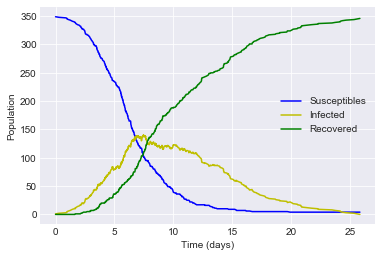

In [3]:
np.random.seed(123)
N = 350
X = N - 1
Y, Z = N - X, 0
y0 = np.array([X, Y, Z], dtype=int)
parameters = np.array([1.0, 0.25], dtype=float)
T = 200
update_basic = np.array([[-1, 1, 0], [0, -1, 1]], dtype=int)

sir = SIR("SIR" ,y0, T, parameters, update_basic)
# data = sir.direct_Gillepsie()
sir.direct_Gillepsie()
sir.plot_dynamics()

<Figure size 396x288 with 0 Axes>

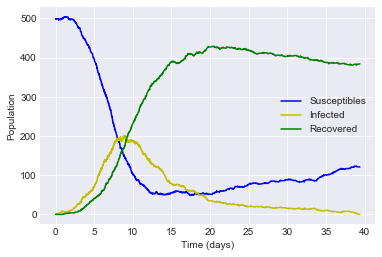

[[20201.26411158  -738.44504242]
 [ -738.44504242  4571.66643318]]


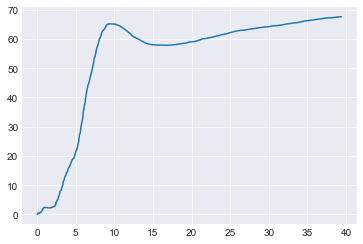

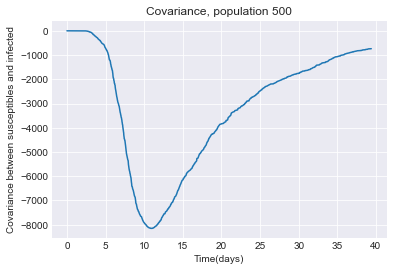

In [14]:
np.random.seed(45)
N = 500
X = N - 1
Y, Z = N - X, 0
T = 50
y0 = np.array([X, Y, Z], dtype=int)
parameters = np.array([1.0, 0.25, 1 / 60, 1 / 60], dtype=float)
update_demography = np.array([[1, 0, 0], [-1, 1, 0], [0, -1, 1], 
                             [-1, 0, 0], [0, -1, 0], [0, 0, -1]], 
                             dtype=int)



sir_demo = SIR("demography", y0, T, parameters, update_demography)
sir_demo.SIR_model3(y0)
sir_demo.direct_Gillepsie()
sir_demo.plot_dynamics()

sir_demo.plot_variance()
# start = time.time()
# sir_demo.simulation(n_sim, pop_sizes, time_periods, perc)
# print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))
# sir_demo.plot_simulation(n_sim, pop_sizes, time_periods)

Notebook ran in 0.549 minutes.


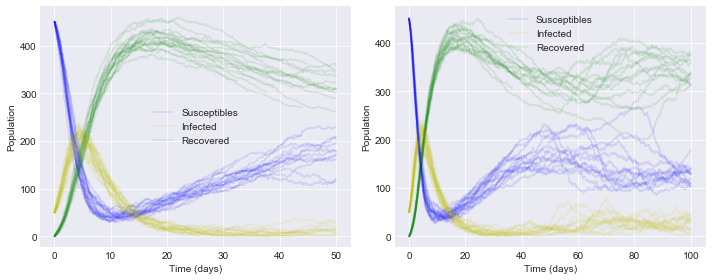

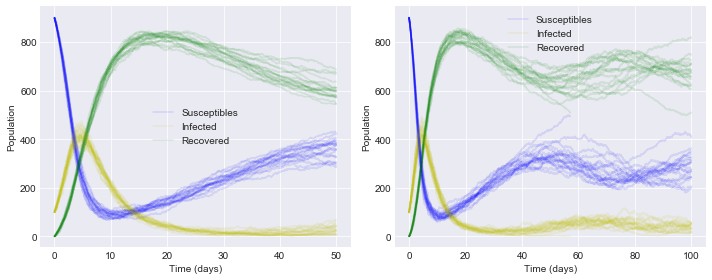

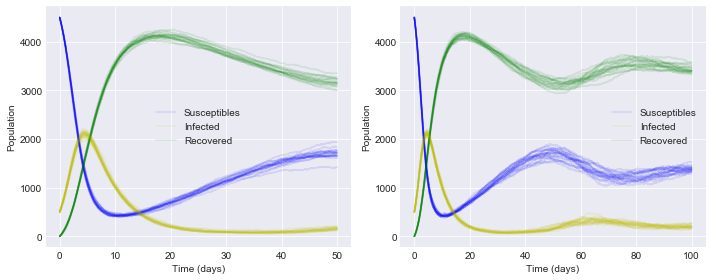

Notebook ran in 0.67 minutes.


In [5]:
n_sim = 20
pop_sizes = [500, 1000, 5000]
time_periods = [50, 100]
perc = 0.90

start = time.time()
sir_demo.simulation(n_sim, pop_sizes, time_periods, perc)
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))
# sir_demo.plot_simulation(n_sim, pop_sizes, time_periods)

start = time.time()
sir_demo.plot_simulation()
# sir_demo.plot_variance()
# print(sir_demo.data)
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

<Figure size 396x288 with 0 Axes>

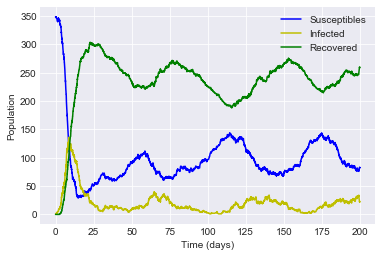

0           50
1           50
2           50
3           51
4           52
5           53
6           52
7           52
8           53
9           54
10          55
11          56
12          55
13          55
14          56
15          55
16          56
17          57
18          58
19          59
20          60
21          60
22          60
23          60
24          61
25          62
26          62
27          61
28          62
29          63
          ... 
1415589    153
1415590    153
1415591    153
1415592    153
1415593    153
1415594    153
1415595    152
1415596    152
1415597    152
1415598    152
1415599    153
1415600    153
1415601    153
1415602    154
1415603    153
1415604    153
1415605    154
1415606    154
1415607    154
1415608    154
1415609    154
1415610    154
1415611    154
1415612    154
1415613    153
1415614    153
1415615    153
1415616    153
1415617    153
1415618    154
Name: Y, Length: 1415619, dtype: object


In [6]:
N = 350
X = N - 1
Y, Z = N - X, 0
T = 200
delta = 0.02
y0 = np.array([X, Y, Z], dtype=int)
parameters = np.array([1.0, 0.25, 1 / 60, 1 / 60, delta], dtype=float)
update_imports = np.array([[1, 0, 0], [-1, 1, 0], [0, -1, 1], 
                             [-1, 0, 0], [0, -1, 0], [0, 0, -1], [0,1,0]], 
                             dtype=int)
sir_imports = SIR("imports", y0, T, parameters, update_imports)
sir_imports.direct_Gillepsie_imports()
sir_imports.plot_dynamics()
print(sir_demo.data["Y"])

In [7]:
# Importing required packages
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as ode
from IPython.display import clear_output
import time

n = 40
nInf = 1

gamma = 0.45
mu = 0.0001
nu = mu


dt = np.linspace(0,1,2)

t, T = 0, 100

list_beta=[]
list_t_beta=[]

# loop through the beta
for i in np.linspace(0.8,3.5,15):  
    N0 = 500*np.ones(n*n)
    S0 = 500*np.ones(n*n)
    I0 = np.zeros(n*n)

    #get the middle of a graph 
    if (n%2) == 0:
        middle = int((n*n)/2)
        S0[middle-int(n/2)] = 499
        I0[middle-int(n/2)] = 1
        S0[middle+int(n/2)] = 499
        I0[middle+int(n/2)] = 1
        S0[middle-int(n/2)-1] = 499
        I0[middle-int(n/2)-1] = 1
        S0[middle+int(n/2)-1] = 499
        I0[middle+int(n/2)-1] = 1
    else:
        middle = int((n*n)/2)
        S0[middle] = 499
        I0[middle] = 1
        
    #middle=int(((n-1)/2+1)*n-((n-1)/2))
    initial_state = np.hstack((N0, I0, S0))
    
    # Looping through the beta
    beta = i
    rho = 0.1
    parameters = beta, gamma, mu, rho, nu
    t=0
    while t < T:
    
 
        lattice_centered = ode.odeint(lattice_model, initial_state, dt, parameters)
        initial_state = lattice_centered[-1]
 
        grid = np.reshape(initial_state, (3, n, n))
    
        
    # 361 is a random number chosen which stops the loop if this gird is infected
    # by doing so we can see for which beta or rho this specific array is reached at what time step t 
    # Thereby the velocity can be computed
        if grid[1][14][0]>1:
            
            list_t_beta.append(t)
            list_beta.append(beta)
            xxx=t
            t=101
        
        
        
        #grid = np.reshape(initial_state, (3, n, n))
        #clear_output(wait=True)
        #fig, ax = plt.subplots(1)
        #ax.set_aspect('equal')
        #p = ax.pcolormesh(grid[1][:][:], vmin=0, vmax=195)
        #fig.colorbar(p)
        #plt.show()
        #print(t)
        #fig.savefig('LatticeSim/GStocPopCenter_'+str(t), dpi=300)
        t += 1
        fig = plt.figure(figsize=(10, 4), facecolor='w')
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()


ax1.plot(list_beta,list_t_beta,'g',alpha=1, lw=2,label=r'$\beta$')
ax2.plot(list_rho,list_t_rho,'b',alpha=1, lw=2,label=r'$\rho$') 
ax1.set_xlabel(r"$\beta$",fontsize=15) 
ax1.set_ylabel("Days to reach end of the grid",fontsize=15) 
ax2.set_xlabel(r'$\rho$',fontsize=15)
#ax1.set_xlim(0.8,3.5)
#ax2.set_xlim(0.08,0.5)
ax1.set_ylim(0,np.max(list_t_beta))

fig.legend(bbox_to_anchor=(.83, .82),fontsize=15)
ax1.grid()

plt.savefig('Speed_of_disease',dpi=300)
plt.show()

NameError: name 'lattice_model' is not defined